/tmp/ipykernel_121100/1475058504.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


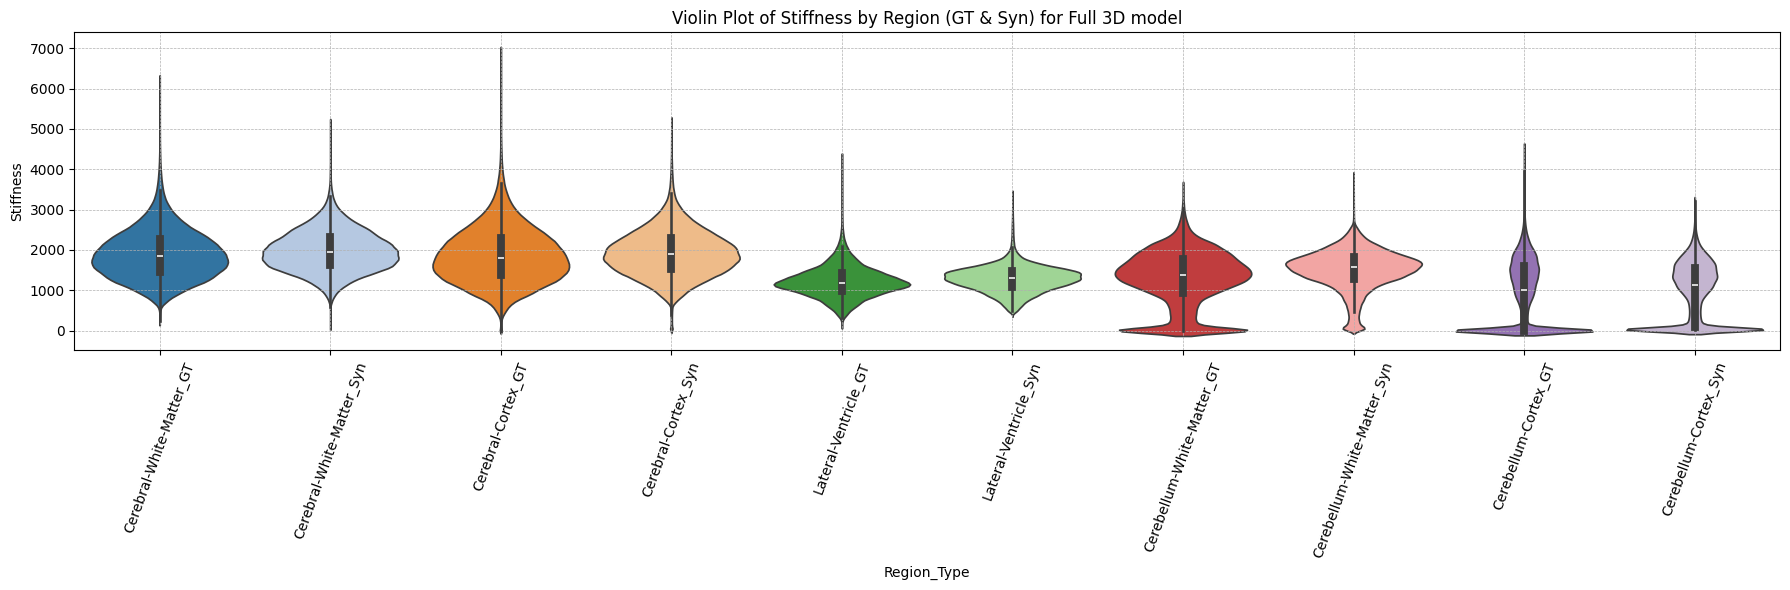

                 Region  GT_Median  Pred_Median  Relative_Error (%)
Cerebellum-White-Matter    1382.72      1572.62               13.73
      Cerebellum-Cortex     995.72      1126.65               13.15
      Lateral-Ventricle    1190.81      1295.12                8.76
  Cerebral-White-Matter    1842.85      1949.51                5.79
        Cerebral-Cortex    1803.27      1898.25                5.27


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

# --- Dictionary mapping labels to regions ---
label_dict = {
    2: "Cerebral-White-Matter",
    3: "Cerebral-Cortex",
    4: "Lateral-Ventricle",
    7: "Cerebellum-White-Matter",
    8: "Cerebellum-Cortex",
    41: "Cerebral-White-Matter",
    42: "Cerebral-Cortex",
    43: "Lateral-Ventricle",
    46: "Cerebellum-White-Matter",
    47: "Cerebellum-Cortex",
    192: "Corpus_Callosum"
}

combined_label_dict = {
    "Cerebral-White-Matter": [2, 41],
    "Cerebral-Cortex": [3, 42],
    "Lateral-Ventricle": [4, 43],
    "Cerebellum-White-Matter": [7, 46],
    "Cerebellum-Cortex": [8, 47],
    "Corpus_Callosum": [192]
}

def load_volume(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

def create_violin_dataframe(gt_list, pred_list, mask_list):
    data = []

    for gt_volume, pred_volume, mask in zip(gt_list, pred_list, mask_list):
        for label_id, region_name in label_dict.items():
            gt_vals = gt_volume[mask == label_id]
            pred_vals = pred_volume[mask == label_id]

            gt_vals = gt_vals[~np.isnan(gt_vals)]
            pred_vals = pred_vals[~np.isnan(pred_vals)]

            for val in gt_vals:
                data.append({'Region': region_name, 'Stiffness': val, 'Type': 'GT'})
            for val in pred_vals:
                data.append({'Region': region_name, 'Stiffness': val, 'Type': 'Syn'})

    df = pd.DataFrame(data)
    df["Region_Type"] = df["Region"] + "_" + df["Type"]
    return df

# --- Base directory ---
base_dir = '/home/maia-user/cifs/Datasets/PD_Private/chrol/ParkMRE'
pred_dir = os.path.join(base_dir, 'ablation_nopreweight_masked3.0/5params_160x192x160/niftimaps_denormalized')
gt_dir = os.path.join(base_dir, 'MRE_T1toMNI_202402')
mask_dir = os.path.join(base_dir, 'Mask_RegionAnalysis')

# --- Load multiple volumes ---
gt_list = []
pred_list = []
mask_list = []

pred_files = glob.glob(os.path.join(pred_dir, '*_prediction_denormalized.nii.gz'))

for pred_file in pred_files:
    subject_id = os.path.basename(pred_file).replace('_prediction_denormalized.nii.gz', '')
    gt_path = os.path.join(gt_dir, subject_id, 'MRE_stiffness_ToT1_202402_t1_to_MNI.nii.gz')
    mask_path = os.path.join(mask_dir, subject_id, 'aseg_to_MNI.mgz')

    if not os.path.exists(gt_path) or not os.path.exists(mask_path):
        print(f"Missing files for {subject_id}, skipping...")
        continue

    try:
        gt_volume = load_volume(gt_path)
        pred_volume = load_volume(pred_file)
        mask_volume = load_volume(mask_path)
        gt_list.append(gt_volume)
        pred_list.append(pred_volume)
        mask_list.append(mask_volume)
    except Exception as e:
        print(f"Error loading {subject_id}: {e}")
        continue

# --- Create aggregated DataFrame ---
df = create_violin_dataframe(gt_list, pred_list, mask_list)

# --- Create palette and plot ---
unique_keys = df["Region_Type"].unique()
palette = sns.color_palette("tab20", len(unique_keys))
palette_dict = dict(zip(unique_keys, palette))

plt.figure(figsize=(18, 6))
sns.violinplot(
    data=df,
    x='Region_Type',
    y='Stiffness',
    inner="box",
    palette=palette_dict
)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title("Violin Plot of Stiffness by Region (GT & Syn) for Full 3D model")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

# --- Compute median and relative error on aggregated data ---
median_data = []

for region_name, label_ids in combined_label_dict.items():
    gt_vals_combined = []
    pred_vals_combined = []

    for gt_volume, pred_volume, mask in zip(gt_list, pred_list, mask_list):
        for label_id in label_ids:
            gt_vals = gt_volume[mask == label_id]
            pred_vals = pred_volume[mask == label_id]

            gt_vals = gt_vals[~np.isnan(gt_vals)]
            pred_vals = pred_vals[~np.isnan(pred_vals)]

            gt_vals_combined.extend(gt_vals)
            pred_vals_combined.extend(pred_vals)

    gt_vals_combined = np.array(gt_vals_combined)
    pred_vals_combined = np.array(pred_vals_combined)

    if len(gt_vals_combined) == 0 or len(pred_vals_combined) == 0:
        continue

    gt_median = np.median(gt_vals_combined)
    pred_median = np.median(pred_vals_combined)
    relative_error = np.abs(pred_median - gt_median) / np.abs(gt_median) if gt_median != 0 else np.nan

    median_data.append({
        "Region": region_name,
        "GT_Median": gt_median,
        "Pred_Median": pred_median,
        "Relative_Error (%)": relative_error * 100
    })

# --- Show error table ---
median_df = pd.DataFrame(median_data)
median_df = median_df.sort_values(by="Relative_Error (%)", ascending=False)
pd.set_option('display.float_format', '{:.2f}'.format)
print(median_df.to_string(index=False))

/tmp/ipykernel_121100/248726470.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


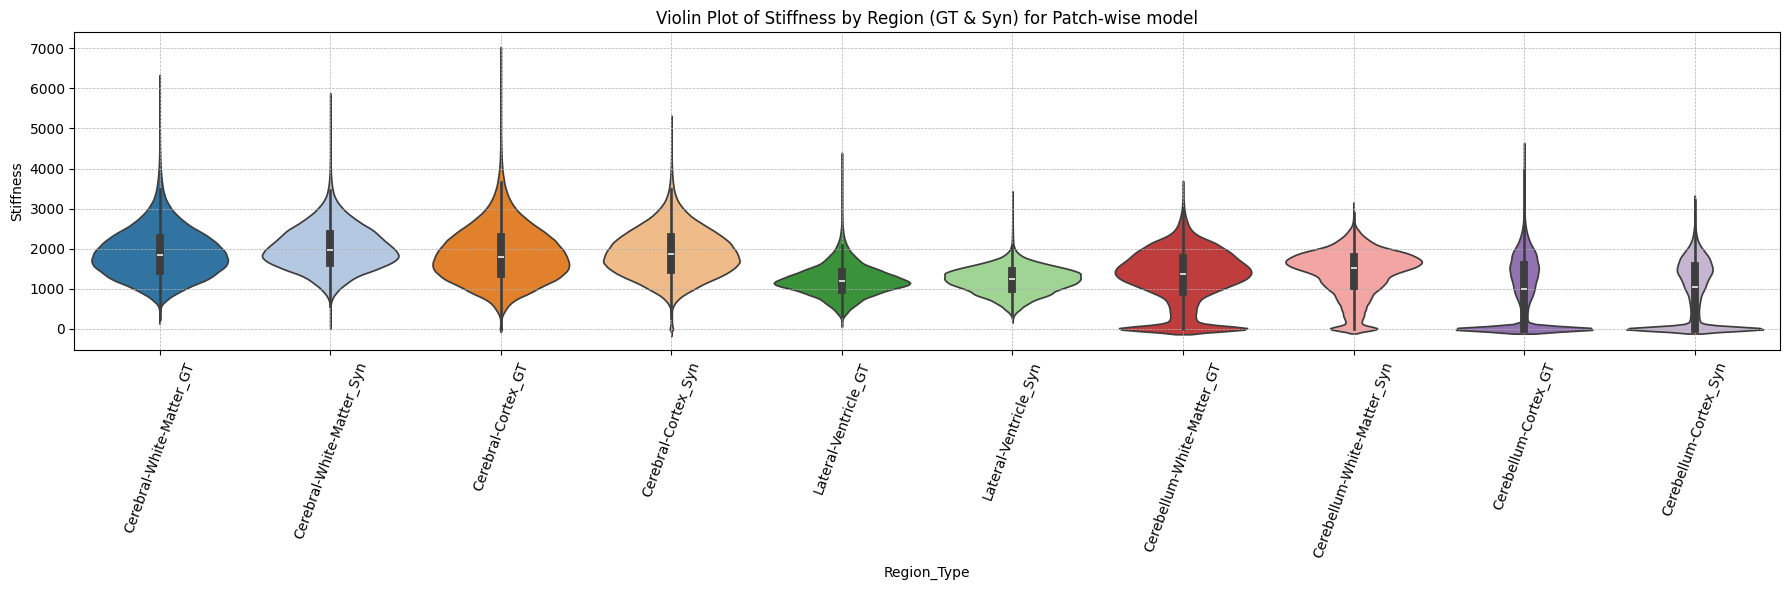

                 Region  GT_Median  Pred_Median  Relative_Error (%)
Cerebellum-White-Matter    1382.72      1529.07               10.58
  Cerebral-White-Matter    1842.85      1978.48                7.36
      Cerebellum-Cortex     995.72      1052.26                5.68
      Lateral-Ventricle    1190.81      1234.58                3.68
        Cerebral-Cortex    1803.27      1865.92                3.47


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

# --- Dictionary mapping labels to regions ---
label_dict = {
    2: "Cerebral-White-Matter",
    3: "Cerebral-Cortex",
    4: "Lateral-Ventricle",
    7: "Cerebellum-White-Matter",
    8: "Cerebellum-Cortex",
    41: "Cerebral-White-Matter",
    42: "Cerebral-Cortex",
    43: "Lateral-Ventricle",
    46: "Cerebellum-White-Matter",
    47: "Cerebellum-Cortex",
    192: "Corpus_Callosum"
}

combined_label_dict = {
    "Cerebral-White-Matter": [2, 41],
    "Cerebral-Cortex": [3, 42],
    "Lateral-Ventricle": [4, 43],
    "Cerebellum-White-Matter": [7, 46],
    "Cerebellum-Cortex": [8, 47],
    "Corpus_Callosum": [192]
}

def load_volume(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

def create_violin_dataframe(gt_list, pred_list, mask_list):
    data = []

    for gt_volume, pred_volume, mask in zip(gt_list, pred_list, mask_list):
        for label_id, region_name in label_dict.items():
            gt_vals = gt_volume[mask == label_id]
            pred_vals = pred_volume[mask == label_id]

            gt_vals = gt_vals[~np.isnan(gt_vals)]
            pred_vals = pred_vals[~np.isnan(pred_vals)]

            for val in gt_vals:
                data.append({'Region': region_name, 'Stiffness': val, 'Type': 'GT'})
            for val in pred_vals:
                data.append({'Region': region_name, 'Stiffness': val, 'Type': 'Syn'})

    df = pd.DataFrame(data)
    df["Region_Type"] = df["Region"] + "_" + df["Type"]
    return df

# --- Base directory ---
base_dir = '/home/maia-user/cifs/Datasets/PD_Private/chrol/ParkMRE'
pred_dir = os.path.join(base_dir, 'Patchwise/5params_patchwise64_stride32_justnorm/niftimaps_denormalized')
gt_dir = os.path.join(base_dir, 'MRE_T1toMNI_202402')
mask_dir = os.path.join(base_dir, 'Mask_RegionAnalysis')

# --- Load multiple volumes ---
gt_list = []
pred_list = []
mask_list = []

pred_files = glob.glob(os.path.join(pred_dir, '*_pred_denormalized.nii.gz'))

for pred_file in pred_files:
    subject_id = os.path.basename(pred_file).replace('_pred_denormalized.nii.gz', '')
    gt_path = os.path.join(gt_dir, subject_id, 'MRE_stiffness_ToT1_202402_t1_to_MNI.nii.gz')
    mask_path = os.path.join(mask_dir, subject_id, 'aseg_to_MNI.mgz')

    if not os.path.exists(gt_path) or not os.path.exists(mask_path):
        print(f"Missing files for {subject_id}, skipping...")
        continue

    try:
        gt_volume = load_volume(gt_path)
        pred_volume = load_volume(pred_file)
        mask_volume = load_volume(mask_path)
        gt_list.append(gt_volume)
        pred_list.append(pred_volume)
        mask_list.append(mask_volume)
    except Exception as e:
        print(f"Error loading {subject_id}: {e}")
        continue

# --- Create aggregated DataFrame ---
df = create_violin_dataframe(gt_list, pred_list, mask_list)

# --- Create palette and plot ---
unique_keys = df["Region_Type"].unique()
palette = sns.color_palette("tab20", len(unique_keys))
palette_dict = dict(zip(unique_keys, palette))

plt.figure(figsize=(18, 6))
sns.violinplot(
    data=df,
    x='Region_Type',
    y='Stiffness',
    inner="box",
    palette=palette_dict
)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title("Violin Plot of Stiffness by Region (GT & Syn) for Patch-wise model")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

# --- Compute median and relative error on aggregated data ---
median_data = []

for region_name, label_ids in combined_label_dict.items():
    gt_vals_combined = []
    pred_vals_combined = []

    for gt_volume, pred_volume, mask in zip(gt_list, pred_list, mask_list):
        for label_id in label_ids:
            gt_vals = gt_volume[mask == label_id]
            pred_vals = pred_volume[mask == label_id]

            gt_vals = gt_vals[~np.isnan(gt_vals)]
            pred_vals = pred_vals[~np.isnan(pred_vals)]

            gt_vals_combined.extend(gt_vals)
            pred_vals_combined.extend(pred_vals)

    gt_vals_combined = np.array(gt_vals_combined)
    pred_vals_combined = np.array(pred_vals_combined)

    if len(gt_vals_combined) == 0 or len(pred_vals_combined) == 0:
        continue

    gt_median = np.median(gt_vals_combined)
    pred_median = np.median(pred_vals_combined)
    relative_error = np.abs(pred_median - gt_median) / np.abs(gt_median) if gt_median != 0 else np.nan

    median_data.append({
        "Region": region_name,
        "GT_Median": gt_median,
        "Pred_Median": pred_median,
        "Relative_Error (%)": relative_error * 100
    })

# --- Show error table ---
median_df = pd.DataFrame(median_data)
median_df = median_df.sort_values(by="Relative_Error (%)", ascending=False)
pd.set_option('display.float_format', '{:.2f}'.format)
print(median_df.to_string(index=False))